In [4]:
from __future__ import print_function
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
#from pims import TiffStack
import torch
import skimage
import tensorflow as tf

import keras
#Basic NN packages
import keras.layers as kl
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten, Input, AveragePooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import keras.preprocessing.image as kpi
from keras.utils import plot_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.regularizers import l2
from keras.models import load_model

In [5]:
def load_csv(csv_path):
    data = []
    with open(csv_path, 'r') as csv_file:
        headers = csv_file.readline().strip().split(',')
    #Obtaining column indices of each valuetype
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('"X')]
    y_cols = [i for i in range(len(headers)) if headers[i].startswith('"Y')]
    z_col = [i for i in range(len(headers)) if headers[i].startswith('"Z')]
    size_col = [i for i in range(len(headers)) if headers[i].startswith('"size')]
    coordinate_cols = np.append(np.append(np.append(x_cols,y_cols), z_col), size_col)
    cycle_cols = [i for i in range(len(headers)) if headers[i].startswith('"Cyc')]
    
    #NEW
    cell_coordinates = np.core.defchararray.replace(np.loadtxt(csv_path, dtype='str', delimiter=',', skiprows=1, usecols=coordinate_cols), '"', '').astype(np.int32)
    x = cell_coordinates[:,0]
    y = cell_coordinates[:,2]
    cell_coordinates = np.append(x[:,np.newaxis], y[:,np.newaxis], axis=1)
    expression_levels = np.core.defchararray.replace(np.loadtxt(csv_path, dtype='str', delimiter=',', skiprows=1, usecols=cycle_cols), '"', '').astype(np.float64)
    channel_names = headers[8:-1]
    return cell_coordinates, expression_levels, channel_names

In [6]:
def loadImage(fileName):
    return imread(fileName)

In [7]:
def makeCellImages(H_E_matrix,cell_coordinates,pad, expression_levels, region):
    print("iter")
    H_E_shape = np.shape(H_E_matrix)
    num_cells = np.shape(cell_coordinates)[0]
    image = H_E_matrix
    shifted_cell_coords = cell_coordinates
    #image = np.pad(H_E_matrix,((pad,pad), (pad,pad), (0,0)),'edge')
    cell_images = []
    index_preserver = 0
    print("entering for loop")
    for i in range(num_cells):
        x = cell_coordinates[i,0]
        y = cell_coordinates[i,1]
        if x < H_E_shape[0] - 16 and x > 16 and y < H_E_shape[1] - 16 and y > 16:
            cell_image = H_E_matrix[(shifted_cell_coords[i,0]-16):(shifted_cell_coords[i,0]+16),(shifted_cell_coords[i,1]-16):(shifted_cell_coords[i,1]+16),:].astype(np.float32)
            if np.shape(cell_image)[0]==32 and np.shape(cell_image)[1]==32:
                implot = plt.imshow(cell_image)
                plt.show()
                cell_images.append(cell_image)
            else:
                expression_levels = np.delete(expression_levels, i - index_preserver, axis=0)
                index_preserver=index_preserver+1
        else:
            expression_levels = np.delete(expression_levels, i - index_preserver, axis=0)
            index_preserver=index_preserver+1
    #np.save("/home/jacobbedia/data/training_images/{}cellimages".format(region), cell_images)
    #np.save("/home/jacobbedia/data/labels/{}expression_levels".format(region), expression_levels)
    print(region)
    print("num_cells")
    print(np.shape(cell_images))
    print("num_expressions")
    print(np.shape(expression_levels))

In [8]:
def splitData(data_set, expression_levels):
    num_cells = np.shape(data_set)[0]
    print("num_cells")
    print(num_cells)
    num_cols = np.shape(data_set)[1]
    print("num_cols")
    print(num_cols)
    num_expression_levels = np.shape(expression_levels)[1]
    random_list = np.random.choice(num_cells, num_cells, replace=False)
    trainsplit = int(np.round(.8*num_cells))
    devsplit = int(num_cells-trainsplit)
    
    trainset = np.zeros((trainsplit,32,32,3))
    devset = np.zeros((devsplit,32,32,3))
    
    trainlabels = np.zeros((trainsplit,num_expression_levels))
    devlabels= np.zeros((devsplit,num_expression_levels))
    
    for i in range(num_cells):
        if (i < trainsplit):
            trainset[i] = data_set[random_list[i]]
            trainlabels[i] = expression_levels[random_list[i]]
        elif (i<=trainsplit+devsplit):
            devset[i-trainsplit-1] = data_set[random_list[i]]
            devlabels[i-trainsplit-1] = expression_levels[random_list[i]]
    print(np.shape(trainset))
    print(np.shape(devset))
    """
    for i in range(200):
        implot = plt.imshow(trainset[i,:,:,0])
        plt.show()
        implot = plt.imshow(trainset[i,:,:,1])
        plt.show()
        implot = plt.imshow(trainset[i,:,:,2])
        plt.show()
    """
    """
    np.save('/home/jacobbedia/data/training_images/trainimages', trainset)
    np.save('/home/jacobbedia/data/training_images/devimages', devset)
 
    np.save('/home/jacobbedia/data/labels/trainlabels', trainlabels)
    np.save('/home/jacobbedia/data/labels/devlabels', devlabels)
    """
    X_test = np.load("/home/jacobbedia/data/training_images/reg005cellimages.npy")
    X_test = np.append(X_test, np.load("/home/jacobbedia/data/training_images/reg006cellimages.npy"), axis=0)
    X_test = np.append(X_test, np.load("/home/jacobbedia/data/training_images/reg031cellimages.npy"), axis=0)

    y_test = np.load("/home/jacobbedia/data/labels/reg005expression_levels.npy")
    y_test = np.append(y_test, np.load("/home/jacobbedia/data/labels/reg006expression_levels.npy"), axis=0)
    y_test = np.append(y_test, np.load("/home/jacobbedia/data/labels/reg031expression_levels.npy"), axis=0)
    
    np.save('/home/jacobbedia/data/labels/testimages', X_test)
    np.save('/home/jacobbedia/data/labels/testlabels', y_test)
    print("done")

(1440, 1920, 3)
iter
entering for loop


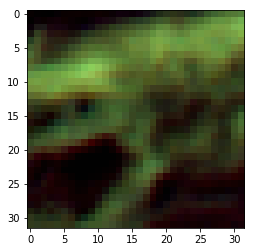

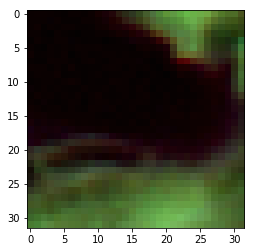

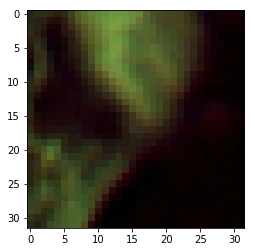

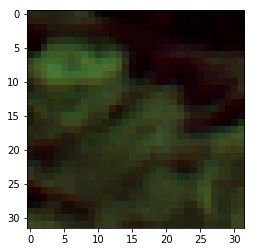

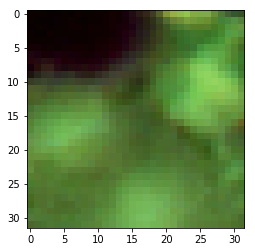

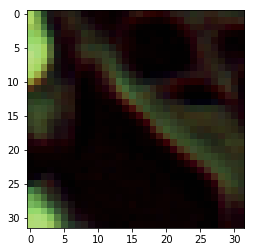

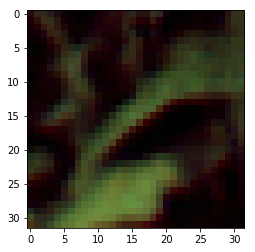

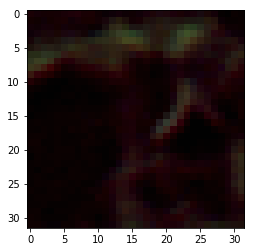

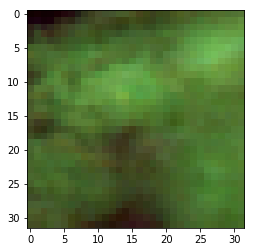

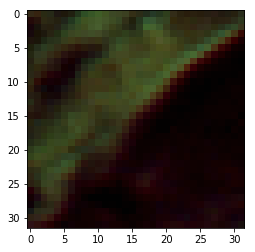

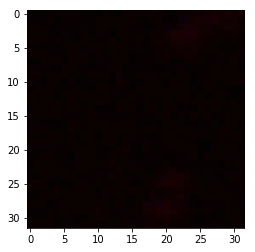

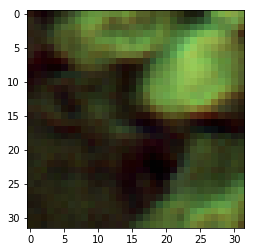

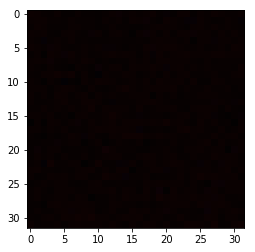

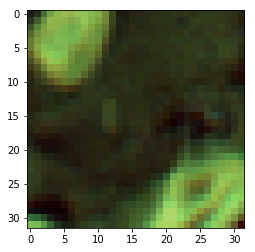

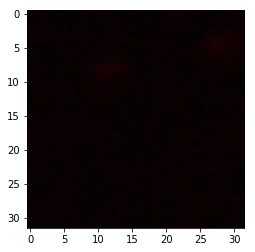

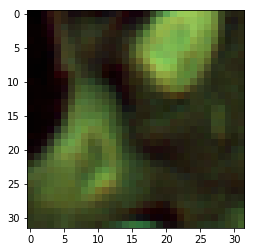

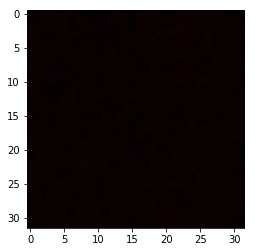

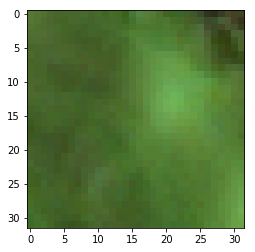

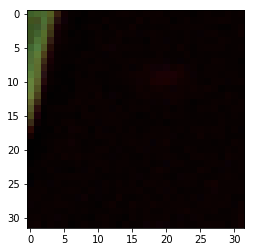

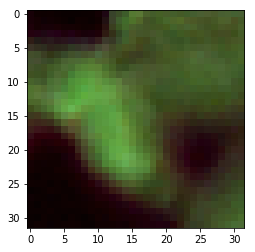

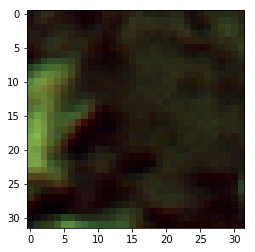

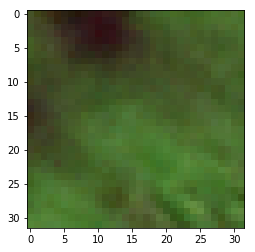

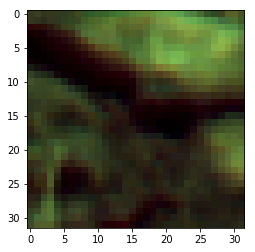

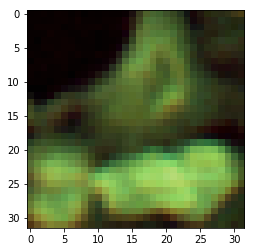

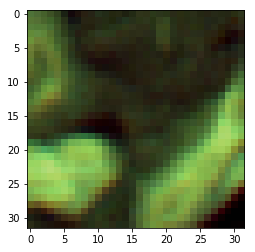

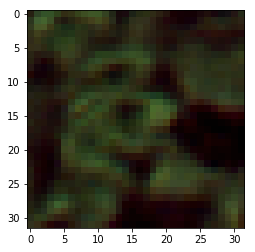

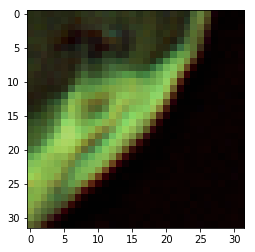

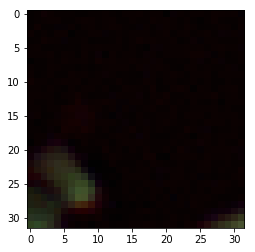

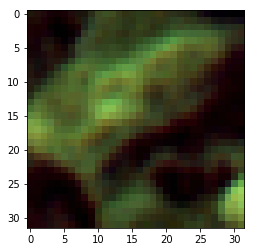

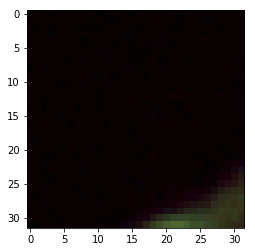

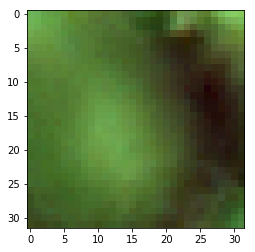

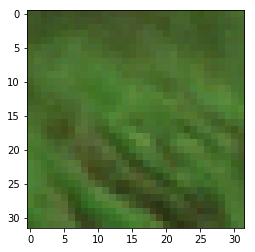

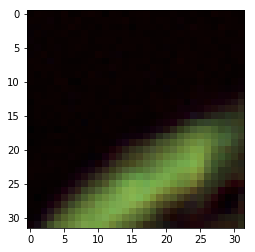

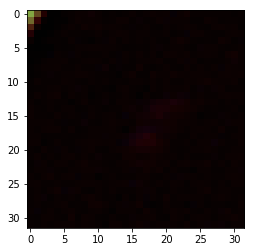

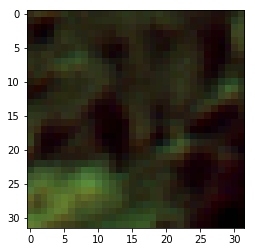

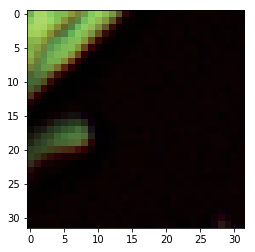

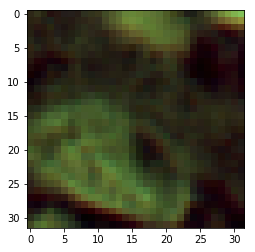

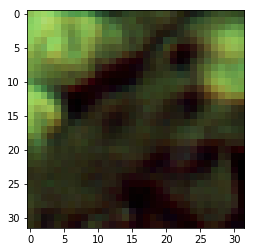

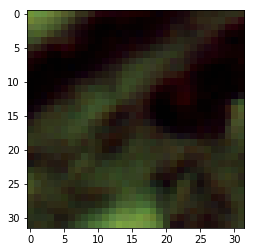

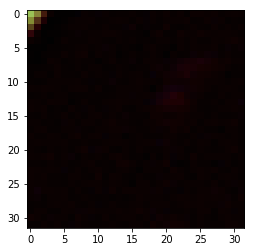

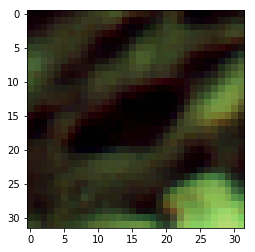

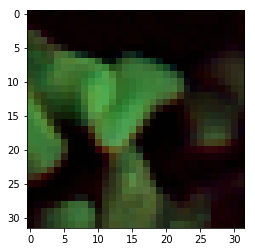

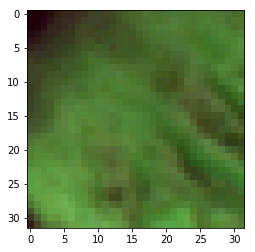

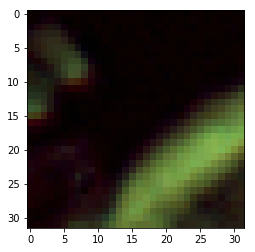

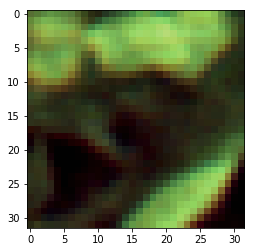

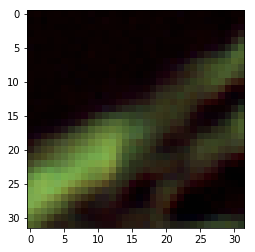

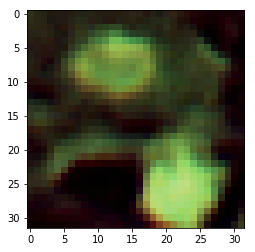

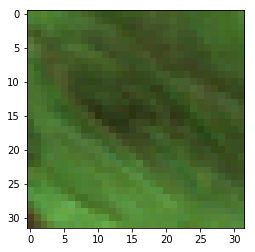

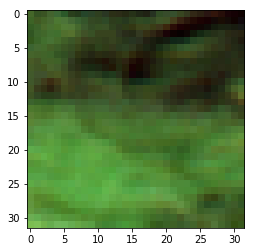

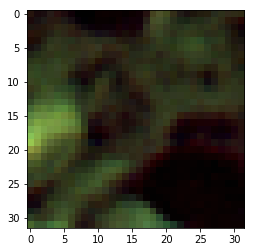

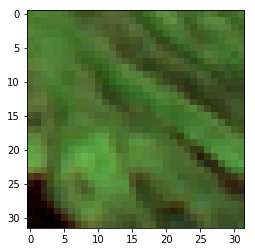

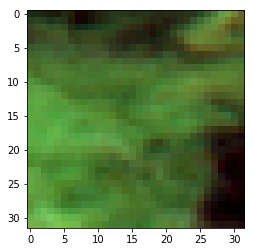

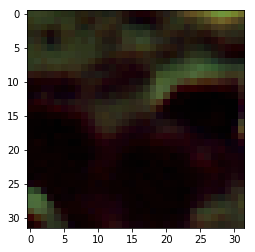

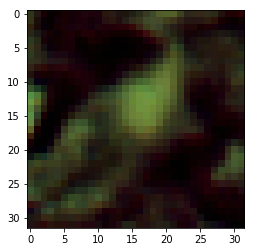

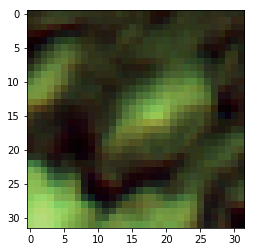

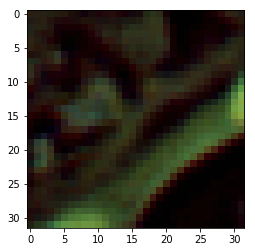

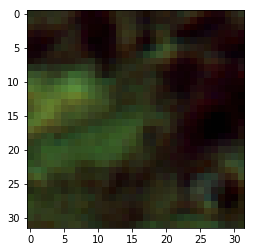

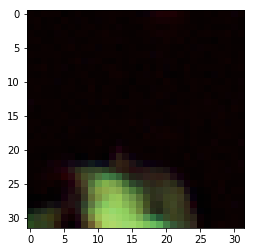

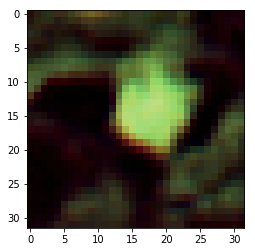

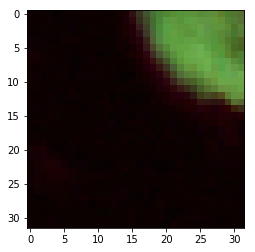

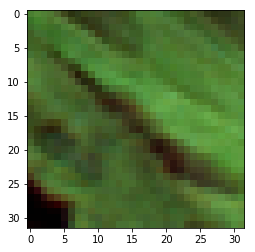

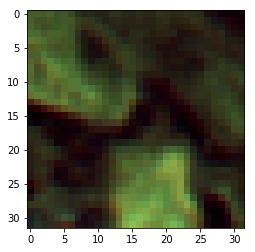

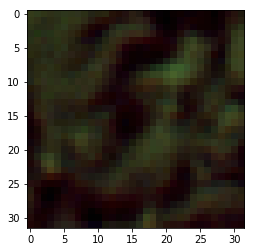

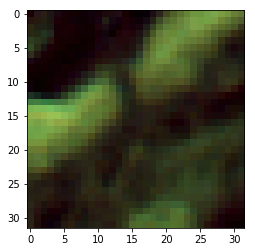

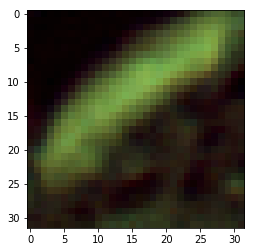

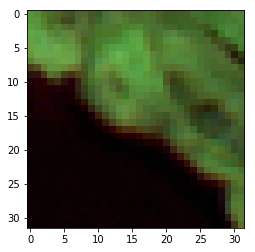

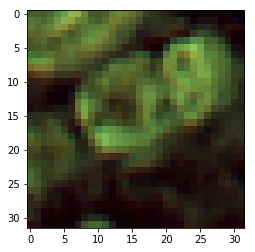

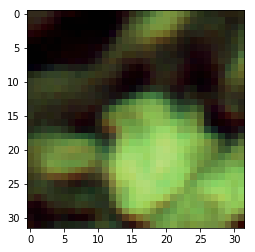

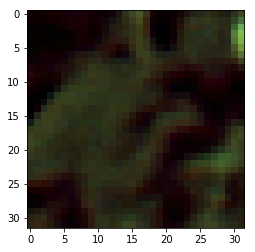

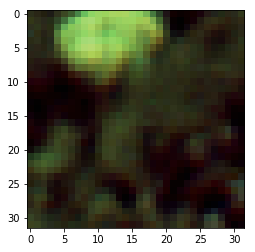

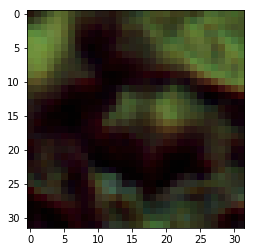

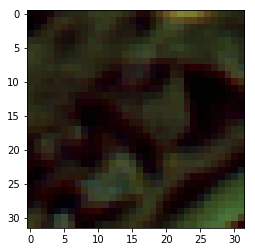

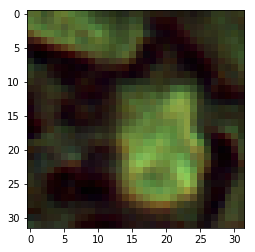

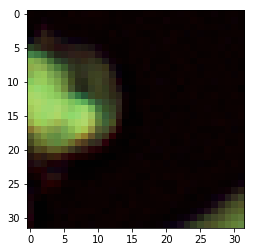

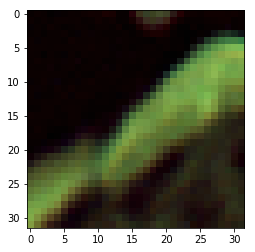

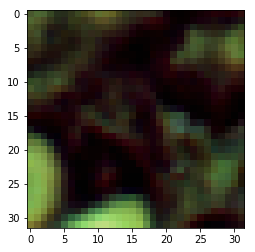

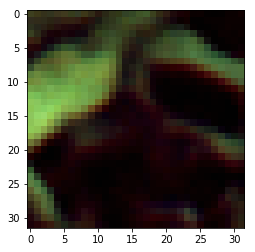

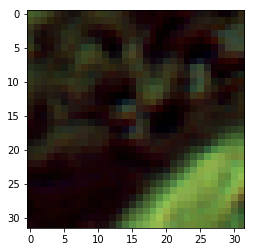

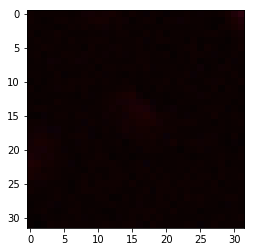

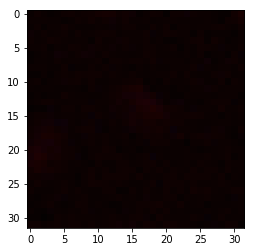

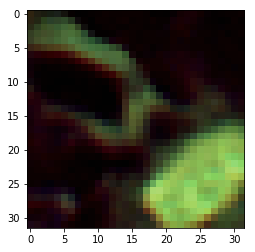

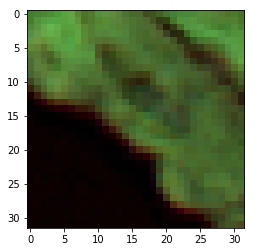

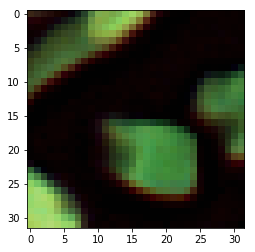

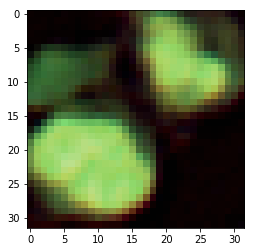

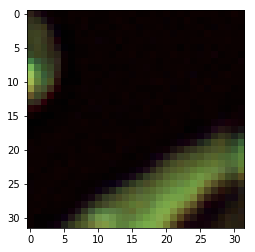

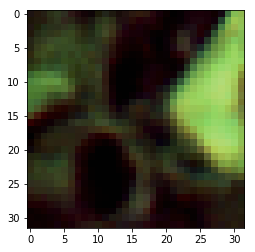

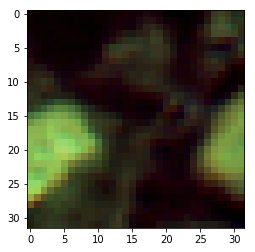

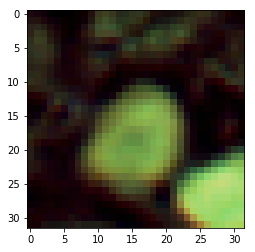

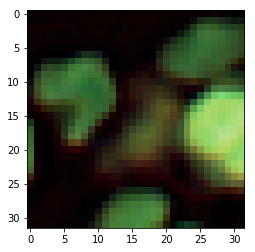

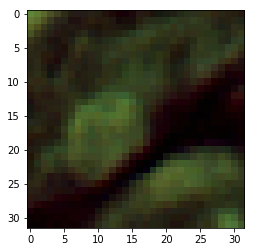

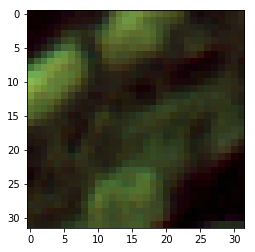

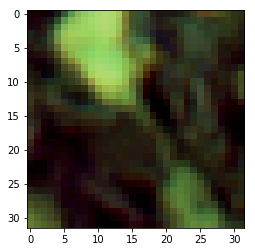

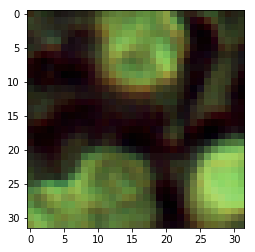

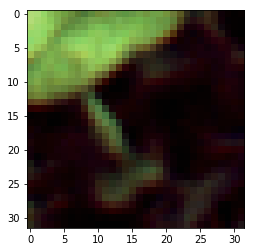

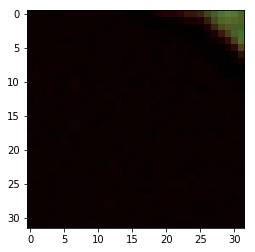

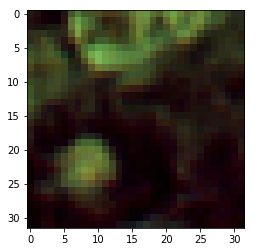

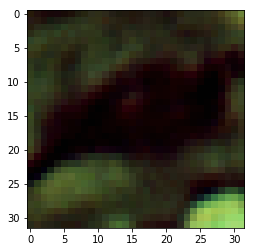

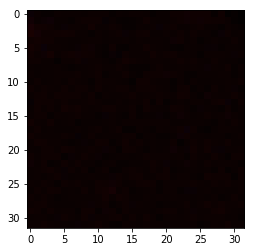

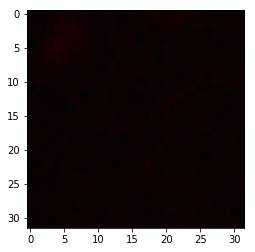

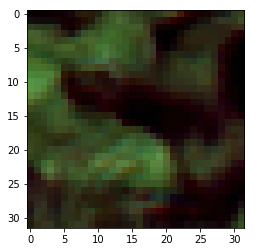

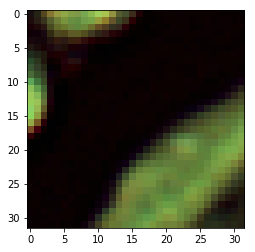

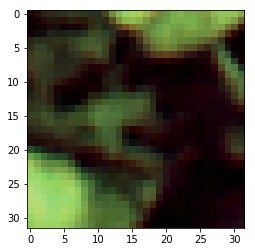

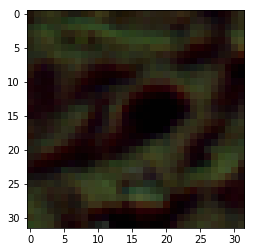

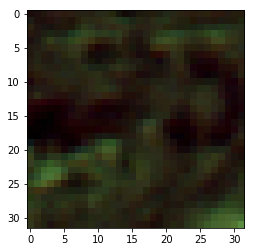

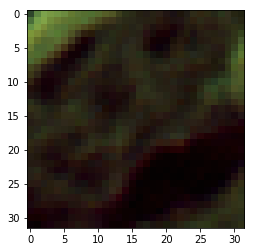

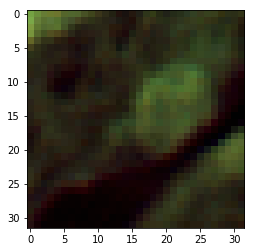

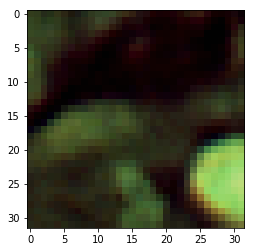

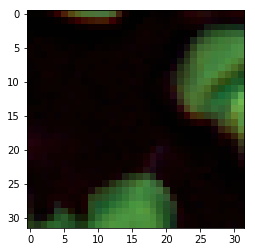

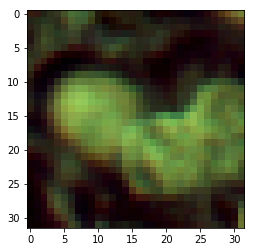

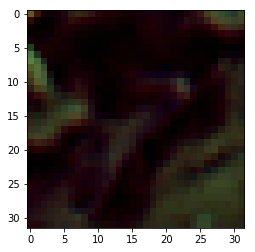

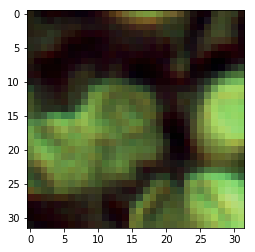

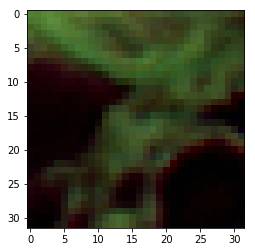

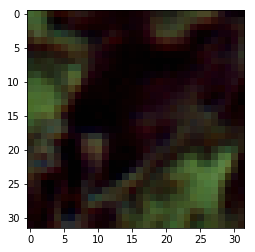

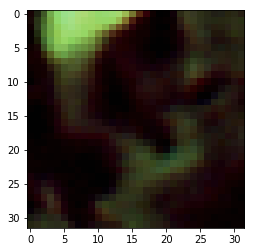

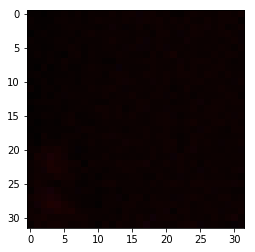

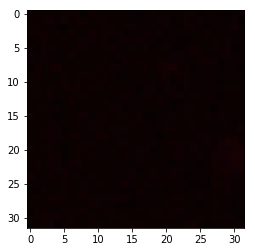

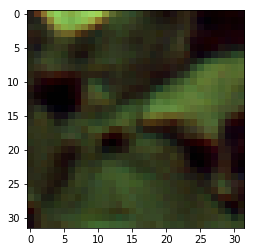

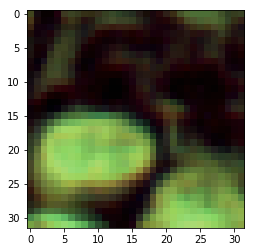

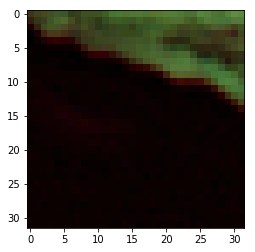

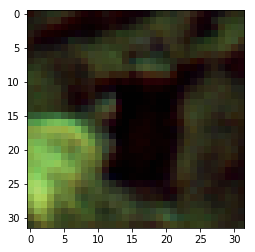

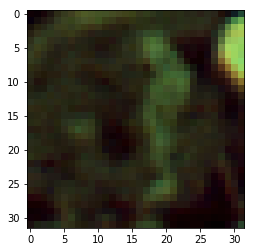

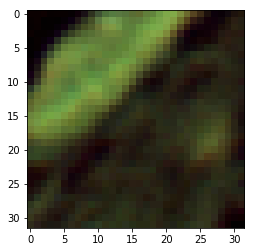

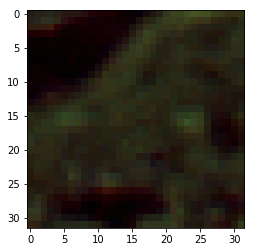

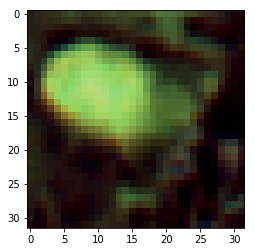

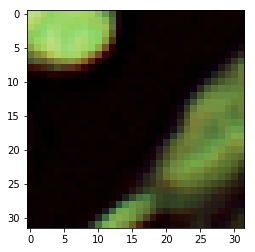

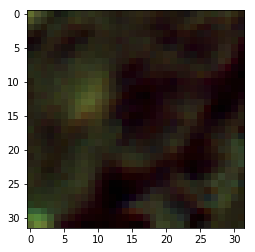

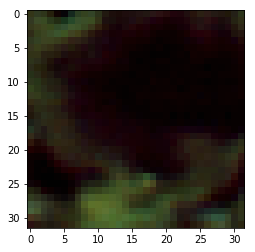

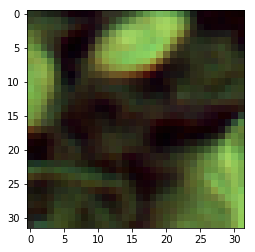

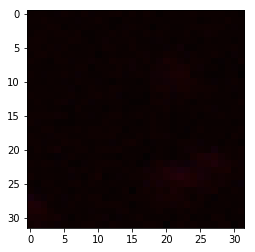

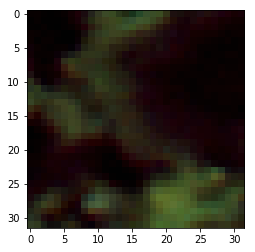

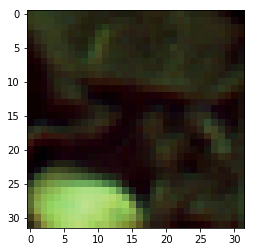

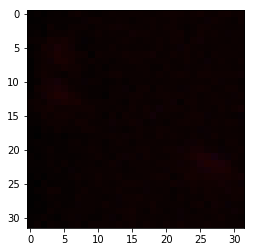

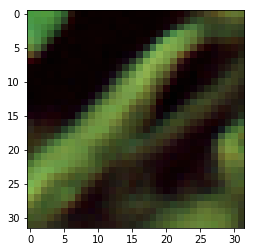

KeyboardInterrupt: 

In [9]:
#following 7 lines are for making single cell 32x32 images
for filename in os.listdir("/home/jacobbedia/data/NewImagesv2/"):
    if filename != ".DS_Store":
        H_E_matrix = loadImage("/home/jacobbedia/data/NewImagesv2/{}".format(filename))
        region = filename[0:6]
        print(np.shape(H_E_matrix))
        cell_coordinates, expression_levels, channel_names = load_csv("/home/jacobbedia/data/CSV_files/{}_Compensated.csv".format(region))
        makeCellImages(H_E_matrix,cell_coordinates,50, expression_levels, region)


#remainder of code is for taking single cell images in train/dev set and randomly assigning them to train or dev set according to split

#X_train = np.load("/home/jacobbedia/data/training_images/reg002cellimages.npy")
#y_train = np.load("/home/jacobbedia/data/labels/reg002expression_levels.npy")
"""
#y_train = (y_train - np.mean(y_train)) / np.std(y_train)
for filename in os.listdir("/home/jacobbedia/data/training_images"):
    if filename.endswith("images.npy") and filename.startswith("reg002")==False and filename.startswith("reg005")==False and filename.startswith("reg006")==False:
        X_train = np.append(X_train, np.load("/home/jacobbedia/data/training_images/{}".format(filename)), axis = 0)
        region = filename[0:6]
        print(region)
        curr_y = np.load("/home/jacobbedia/data/labels/{}expression_levels.npy".format(region))
        #norm_curr_y = (curr_y - np.mean(curr_y)) / np.std(curr_y)
        y_train = np.append(y_train, curr_y, axis=0)
print(np.shape(X_train))
print(np.shape(y_train))
"""
#splitData(X_train, y_train)